In [2]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [3]:
# read the text file
words = open('names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
# build the vocabulary
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(stoi)
print(f'Vocabulary: {vocab_size} characters')

Vocabulary: 27 characters


In [5]:
block_size = 3

# build the dataset
def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # slide the context

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


#### some optimisations
- initial weights and biases should be low

In [6]:
# build the model
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(42)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn(block_size * n_embd, n_hidden, generator=g) * (5/3)/((block_size * n_embd)**0.5)
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad_()

11897


In [7]:
# optimisation 
max_steps = 200000
batch_size = 32
lossi = []

# minibatch contruct
for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y

    # forward pass
    emb = C[Xb] # char embeddings
    embcat = emb.view(-1, block_size * n_embd) # concatenate
    hpreact = embcat @ W1 + b1 # pre-activation
    h = torch.tanh(hpreact) # activation
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update params
    lr = 0.1 if i < (max_steps // 2) else 0.01 # basic lr decay
    for p in parameters:
        p.data -= lr * p.grad

    if i % (max_steps // 10) == 0:
        print(f'iteration {i} loss: {loss.item()}')

    # track stats
    lossi.append(loss.log10().item())

iteration 0 loss: 3.2956013679504395
iteration 20000 loss: 2.5141141414642334
iteration 40000 loss: 2.059892416000366
iteration 60000 loss: 2.056925058364868
iteration 80000 loss: 2.2623987197875977
iteration 100000 loss: 2.16729736328125
iteration 120000 loss: 1.9038201570510864
iteration 140000 loss: 1.8418769836425781
iteration 160000 loss: 2.1798291206359863
iteration 180000 loss: 2.3487050533294678


(array([2310.,  157.,   98.,   80.,   45.,   43.,   26.,   29.,   29.,
          31.,   25.,   27.,   13.,   12.,   21.,   18.,   22.,   18.,
          18.,   18.,   16.,   28.,   21.,   12.,   20.,   11.,   24.,
          24.,   18.,   17.,   19.,   21.,   12.,   16.,   22.,   20.,
          14.,   21.,   17.,   41.,   39.,   26.,   31.,   33.,   41.,
          57.,   62.,   77.,  170., 2430.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

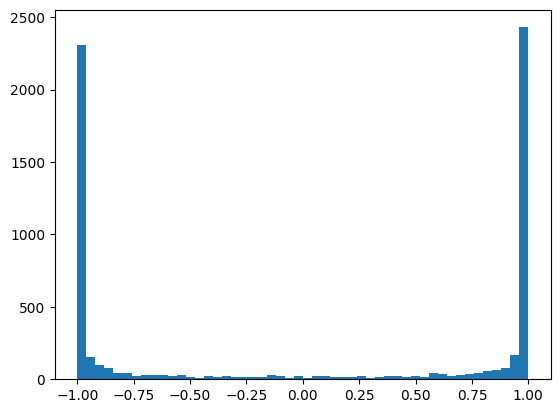

In [ ]:
# observe the activation results after the first iteration
# plt.hist(h.view(-1).tolist(), bins=50)
# plt.hist(hpreact.view(-1).tolist(), bins=50)

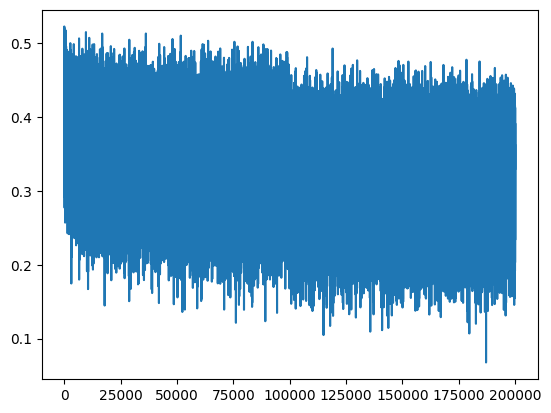

In [73]:
plt.plot(lossi)

In [8]:
@torch.no_grad() # disable gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(-1, block_size * n_embd)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0387990474700928
val 2.1068685054779053


#### initial loss
- train 2.1134796142578125
- val 2.160531520843506

#### after initialising second layer weights and biases lower
- train 2.064913749694824
- val 2.129284381866455

#### after initialising first layer weights and biases lower (tanh was too active after the first iteration)
- train 2.0375447273254395
- val 2.104278802871704

In [12]:
# sample from the model
for _ in range(20):
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        embcat = emb.view(-1, block_size * n_embd)
        h = torch.tanh(embcat @ W1 + b1)
        logits = h @ W2 + b2
        p = F.softmax(logits, dim=1)
        ix = torch.multinomial(p, num_samples=1, generator=g).item()
        if ix == 0:
            break
        print(itos[ix], end='')
        context = context[1:] + [ix]
    print()

ramarkhevyn
ben
elo
lara
anii
nivikaela
dam
eloy
adriantlondy
ashtoki
jaleosielle
shevera
marlyn
aairangal
nodisonow
armangelita
cai
maishel
cyli
arianvorix
